In [1]:
# -------------------------------
#
#        Question 1 
#
# -------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
data = pd.read_csv('pc3_and_pc4_training_data_small_v1.csv')
removed_cols = ['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'wheelbase']
df_train = data.drop(columns=removed_cols)

cols_to_clean = ['back_legroom', 'height', 'length']

# Fill missing entries with NaN
for column in cols_to_clean:
    df_train[column] = df_train[column].replace("--", np.nan).str.replace(" in", "").astype(float)

# Fill missing entries with the average of the column
for column in cols_to_clean:
    average_value = df_train[column].mean()
    df_train[column] = df_train[column].fillna(average_value)

X = data.drop(columns=['price'])

# Extract features and target variable
y_full = df_train['price']  # Target variable
X_full = df_train.drop(['price'], axis=1)  # Features

In [2]:
#categorical_columns = ['body_type', 'exterior_color', 'fuel_type', 'wheel_system']
categorical_columns = ['body_type', 'fuel_type']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_exclude="object")),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

X_transformed = preprocessor.fit_transform(X_full)

In [3]:
categorical_columns = ['body_type', 'fuel_type']
object_imputer = SimpleImputer(strategy='most_frequent').fit(X_full[categorical_columns])
X_full[categorical_columns] = object_imputer.transform(X_full[categorical_columns])

In [2]:
categorical_columns = ['body_type', 'fuel_type']
encoder = OrdinalEncoder()
X_full[categorical_columns] = encoder.fit_transform(X_full[categorical_columns])

In [3]:
# Normialization / Transforming
#X_transformed = preprocessor.fit_transform(X_full)
y_log = np.log1p(y_full)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_full, y_log, test_size=0.2, random_state=0)

In [5]:
print(y_log[0])
print(y_full[0])

9.825309771472105
18495.0


In [4]:
check = False

if check:
    param_grid = {'alpha': np.linspace(1e-7, 1e-4, 10)}
    lasso_model = Lasso(max_iter = 20000)

    grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    best_lasso_model = grid_search.best_estimator_
else:
    best_lasso_model = Lasso(alpha=7.888888888888888e-05, max_iter = 20000)

best_lasso_model.fit(X_train, y_train)

Lasso(alpha=7.888888888888888e-05, max_iter=20000)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

preds = best_lasso_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print(f"Lasso Regression MSE: {mse}")
print(f"Lasso Regression R^2: {r2}")

Lasso Regression MSE: 0.05870222015199944
Lasso Regression R^2: 0.8191332345914482


In [5]:
from sklearn.linear_model import Ridge

check = True

if check:
    param_grid = {'alpha': np.logspace(-3, 4, 6)}  # Different alpha values for Ridge
    
    ridge_model = Ridge()

    grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    best_ridge_model = grid_search.best_estimator_
else:
    best_ridge_model = Ridge(alpha=1.0)

best_ridge_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters: {'alpha': 15.84893192461111}


Ridge(alpha=15.84893192461111)

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

preds_ridge = best_ridge_model.predict(X_test)

mse = mean_squared_error(y_test, preds_ridge)
r2 = r2_score(y_test, preds_ridge)
print(f"Lasso Regression MSE: {mse}")
print(f"Lasso Regression R^2: {r2}")

Lasso Regression MSE: 0.05784703171307333
Lasso Regression R^2: 0.8229197441700904


In [6]:
test_data = pd.read_csv('pc4_test_data_without_response_v1.csv')
df_test = test_data.drop(columns=removed_cols)

# Fill missing entries with NaN
for column in cols_to_clean:
    df_test[column] = df_test[column].replace("--", np.nan).str.replace(" in", "").astype(float)

# Fill missing entries with the average of the column
for column in cols_to_clean:
    average_value = df_test[column].mean()
    df_test[column] = df_test[column].fillna(average_value)

# Extract features and target variable
yTest = df_test['price']  # Target variable
XTest = df_test.drop(['price'], axis=1)  # Features

encoder = OrdinalEncoder()
XTest[categorical_columns] = encoder.fit_transform(XTest[categorical_columns])
yTest = np.log1p(yTest)

In [19]:
final_preds = best_lasso_model.predict(XTest)
final_preds = pd.DataFrame(final_preds)
final_preds.to_csv("final_preds.csv", index=False, header=False)

[ 2  8  3  1  5  6  4  0  7  9 10 11 12 13 14 15 16]


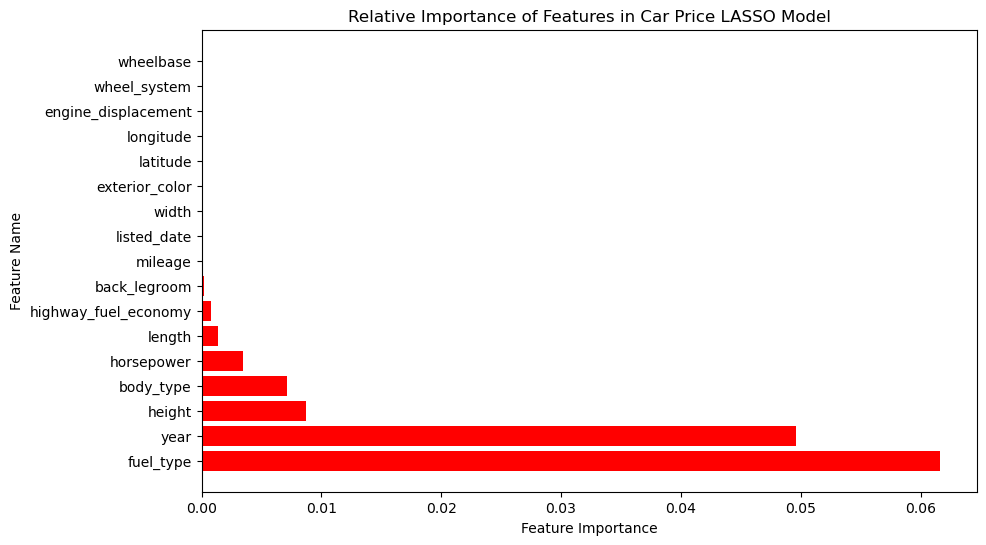

In [7]:
import matplotlib.pyplot as plt

#feats = X.columns
#print(feats)

# Extract feature importance from the best Lasso model
lasso_coefficients = best_lasso_model.coef_
lasso_coefficients = np.abs(lasso_coefficients)
#print(lasso_coefficients)
sorted_indices = lasso_coefficients.argsort()[::-1]
#print(sorted_indices)
#print(lasso_coefficients)

# Get feature names from the original dataset
feature_names = pd.DataFrame(X_train).columns
#print(feature_names.shape)

# Create a DataFrame to store coefficients and feature names
#coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefficients})
#coefficients_df.set_index('Feature', inplace=True)
#print(coefficients_df)

removed = np.asarray(['listed_date', 'width', 'exterior_color', 'latitude', 'longitude', 'engine_displacement', 'wheel_system', 'wheelbase'])
null_weights = np.asarray([0,0,0,0,0,0,0,0])
#print(feature_names.shape)
#print(removed.shape)
feats = np.concatenate((feature_names, removed))
coeffs = np.concatenate((lasso_coefficients, null_weights))
sorted_indices = np.concatenate((sorted_indices, range(9,17)))
print(sorted_indices)

#feature_names.append(removed)

# Plot the variable importance
plt.figure(figsize=(10, 6))
plt.barh(range(0,17), coeffs[sorted_indices], color="red")
plt.yticks(range(0,17), feats[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Relative Importance of Features in Car Price LASSO Model')
plt.show()

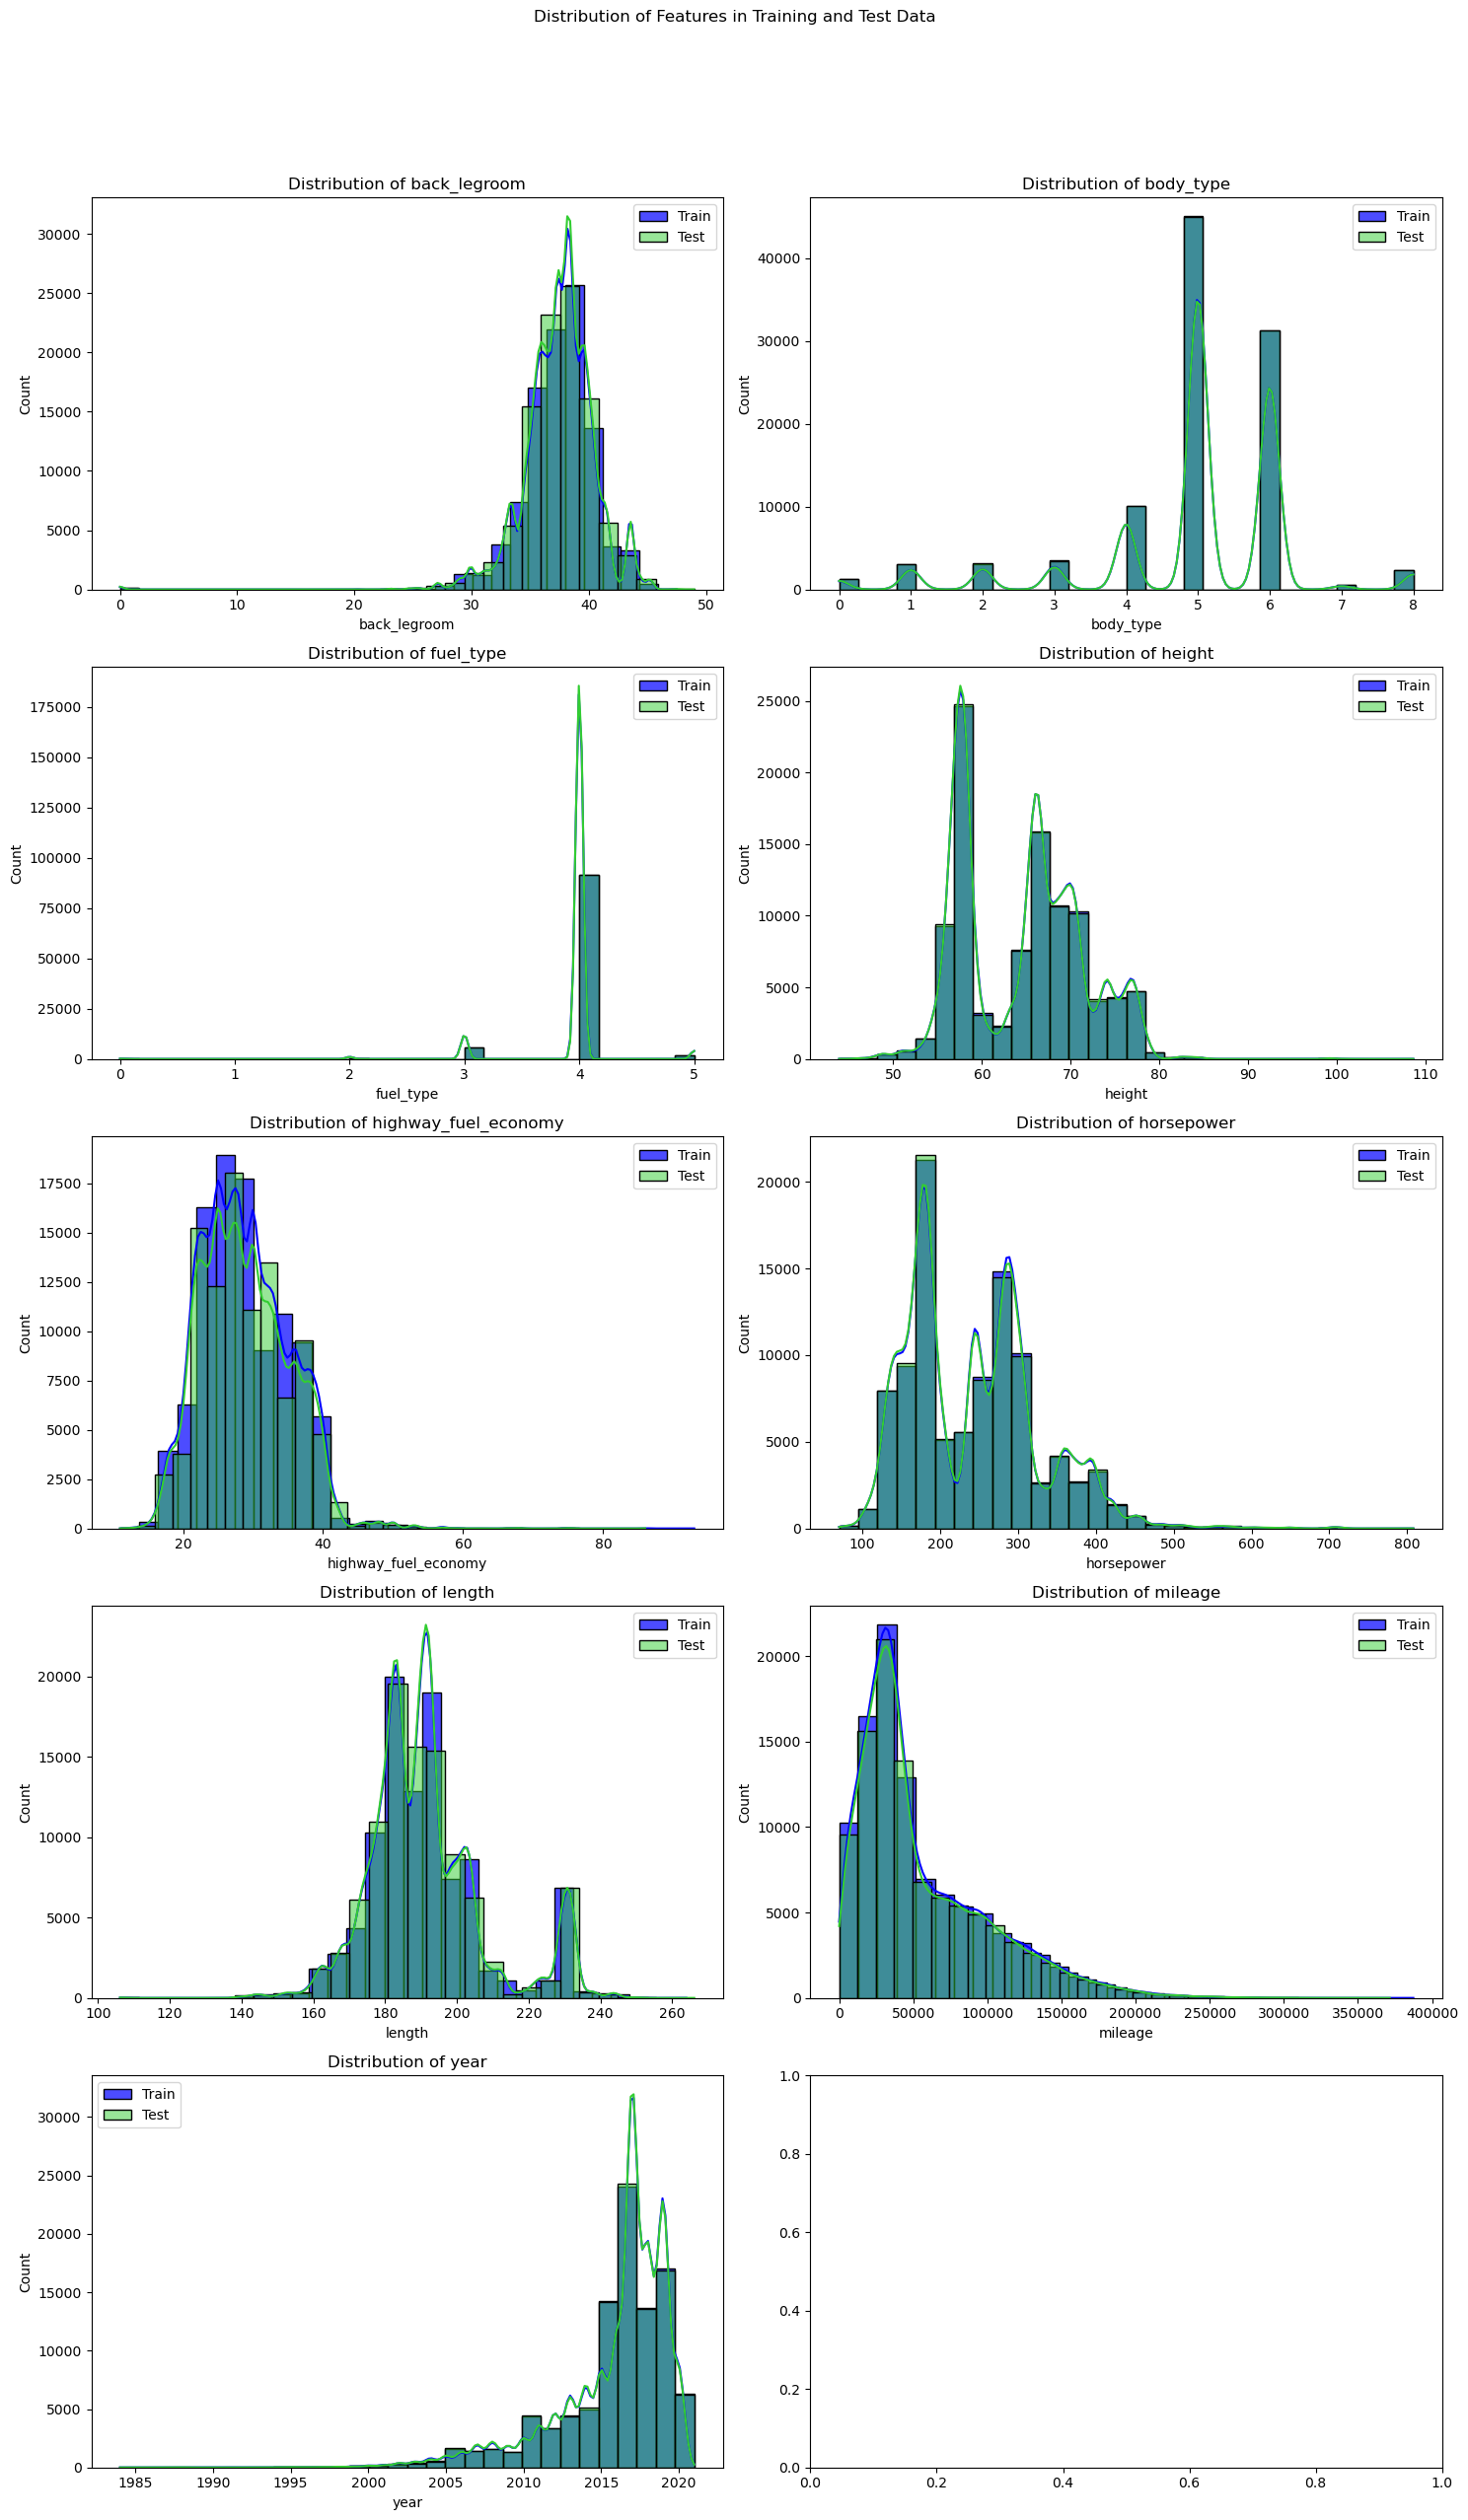

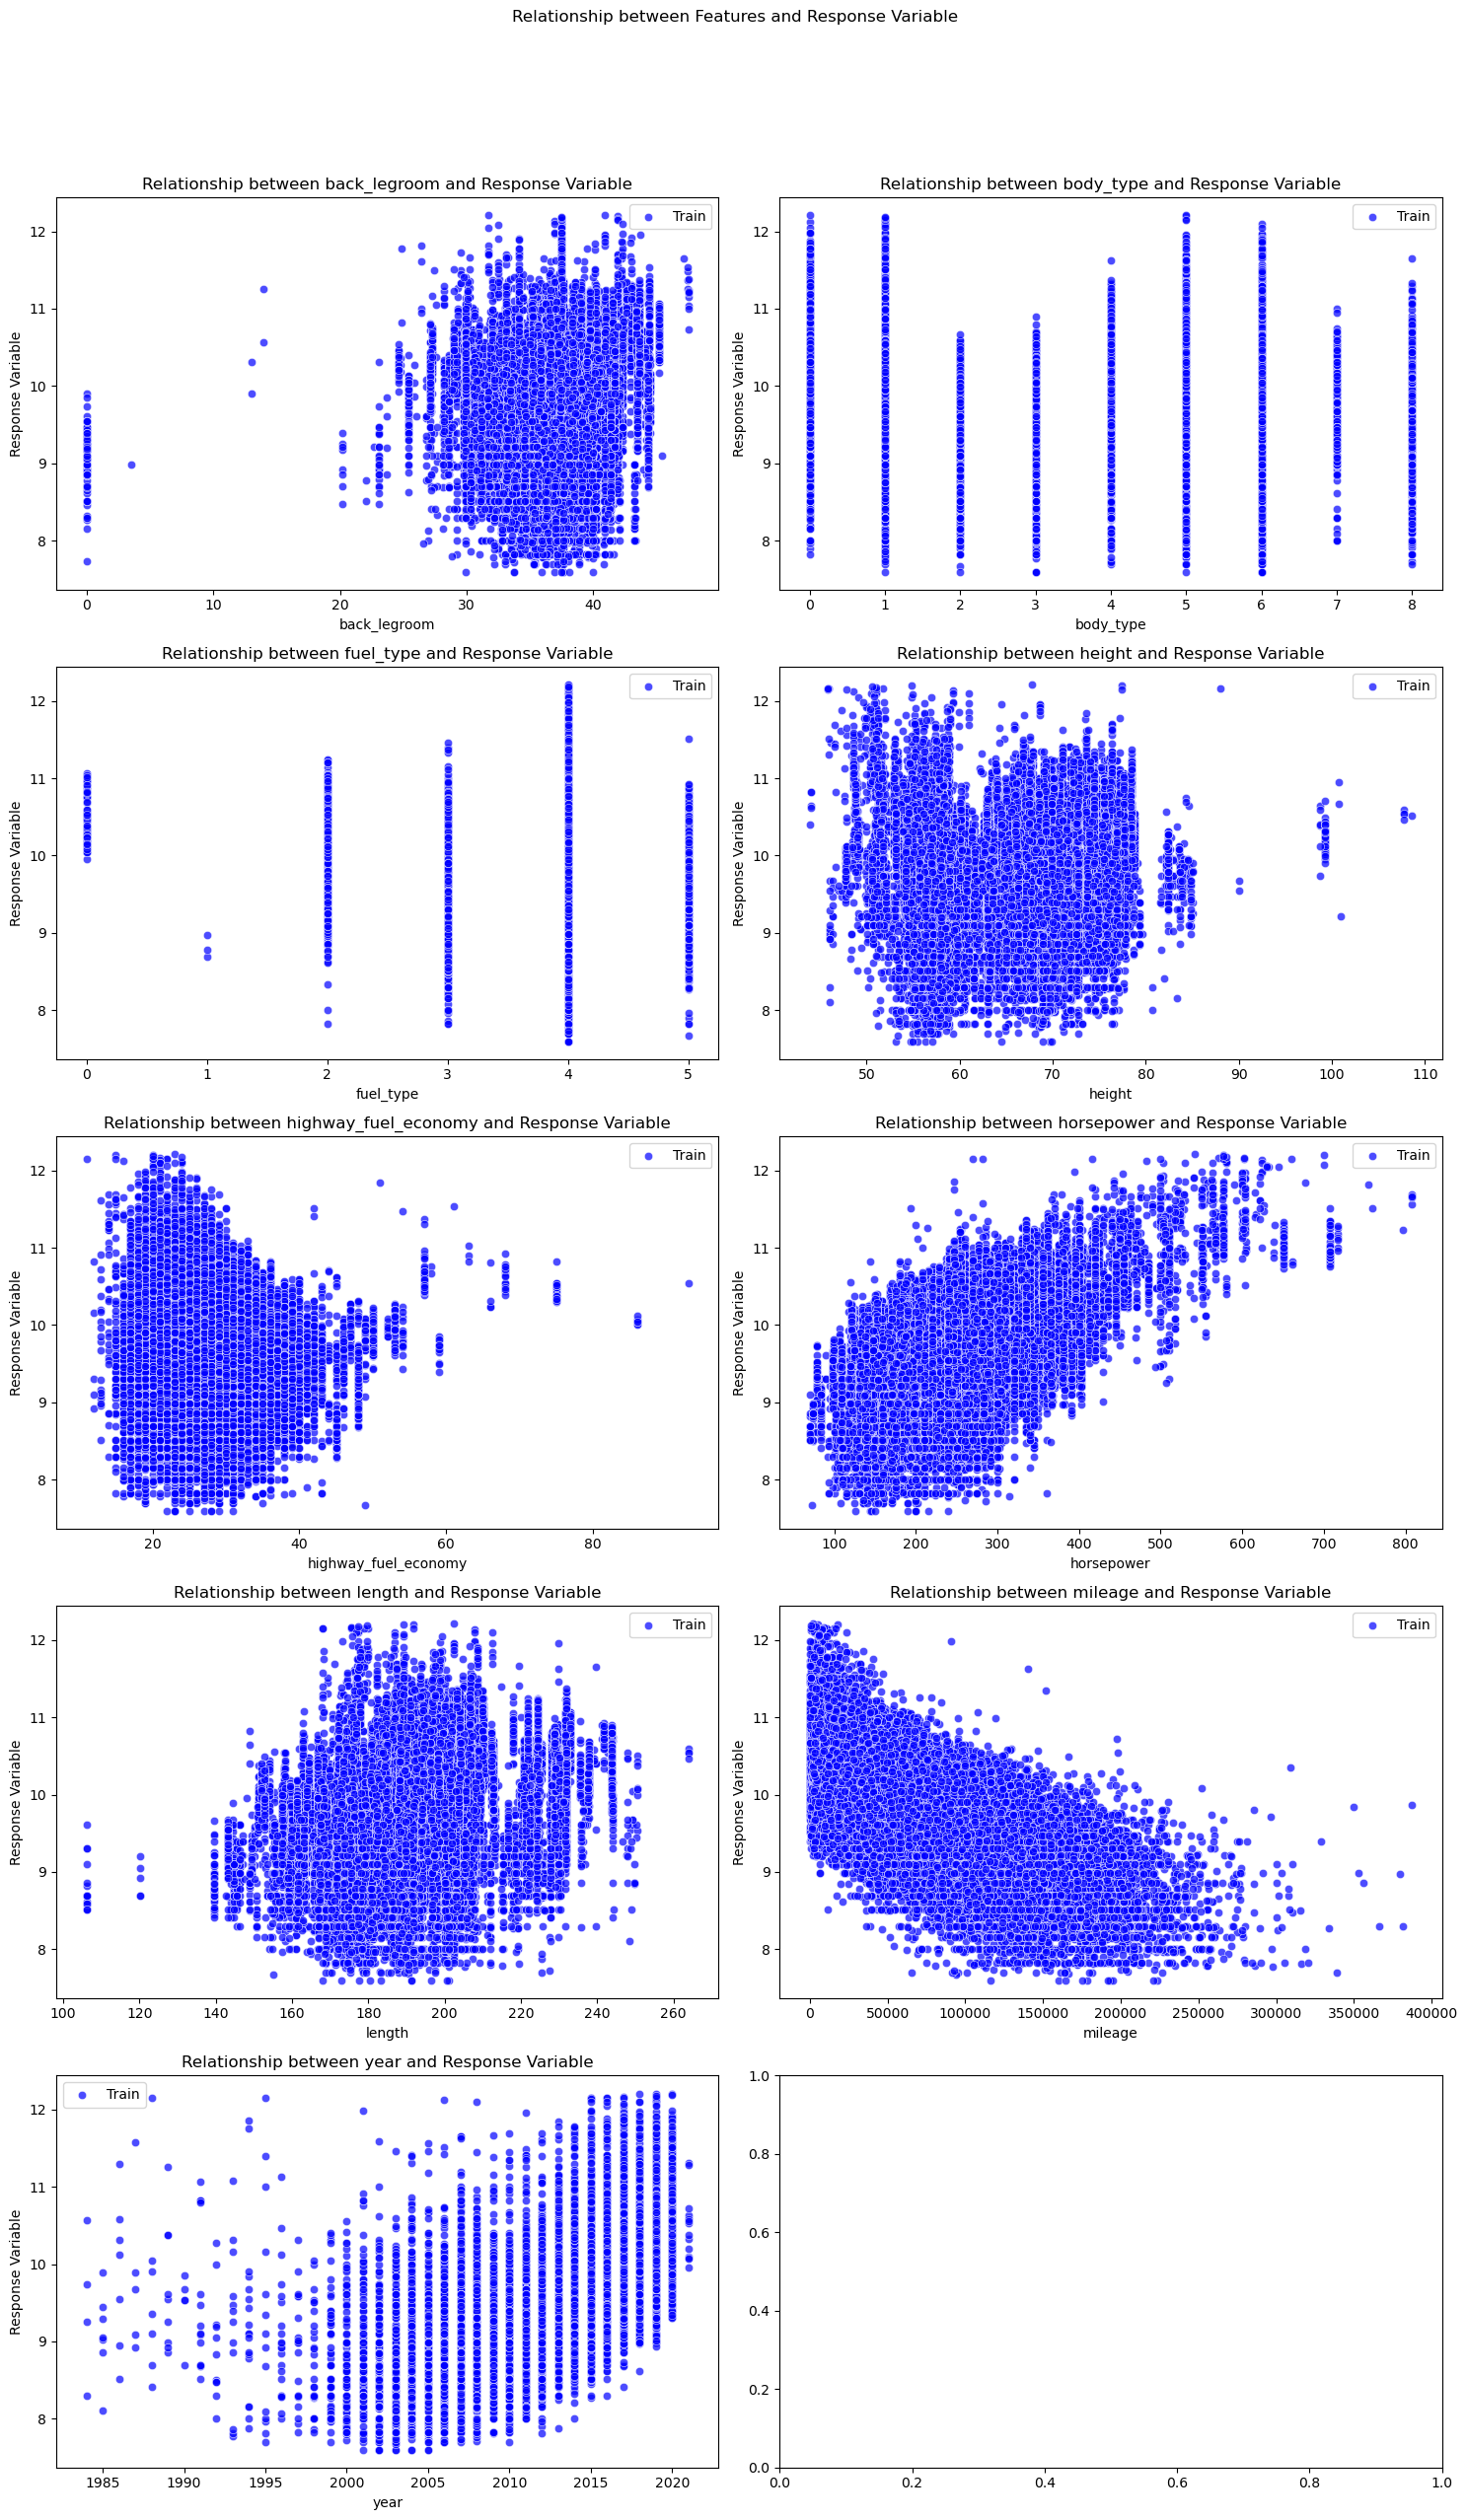

In [13]:
# -------------------------------
#
#        Question 3
#
# -------------------------------

import seaborn as sns

# Combine training and test data for visualization
combined_data = pd.concat([X_full, XTest], keys=['Train', 'Test'])

# Set up subplots for distribution of each feature
num_features = len(X_full.columns)
num_rows_dist = num_features // 2 + num_features % 2
fig_dist, axes_dist = plt.subplots(num_rows_dist, 2, figsize=(15, 5 * num_rows_dist))
fig_dist.suptitle('Distribution of Features in Training and Test Data', y=1.02)
fig_dist.subplots_adjust(hspace=0.5)

for i, feature in enumerate(X_full.columns):
    row, col = divmod(i, 2)
    ax = axes_dist[row, col]
    sns.histplot(combined_data.loc['Train', feature], bins=30, kde=True, ax=ax, label='Train', color='blue', alpha=0.7)
    sns.histplot(combined_data.loc['Test', feature], bins=30, kde=True, ax=ax, label='Test', color='limegreen', alpha=0.5)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust layout for both plots
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Set up subplots for the relationship between each feature and the response variable
num_rows_relation = num_features // 2 + num_features % 2  # Adjusted this line
fig_relation, axes_relation = plt.subplots(num_rows_relation, 2, figsize=(15, 5 * num_rows_relation))  # Adjusted this line
fig_relation.suptitle('Relationship between Features and Response Variable', y=1.02)
fig_relation.subplots_adjust(hspace=0.5)

for i, feature in enumerate(X_train.columns):
    row, col = divmod(i, 2)
    ax = axes_relation[row, col]
    sns.scatterplot(x=combined_data.loc['Train', feature], y=y_log, ax=ax, label='Train', color='blue', alpha=0.7)
    #sns.scatterplot(x=combined_data.loc['Test', feature], y=y_test, ax=ax, label='Test', color='limegreen', alpha=0.5)
    ax.set_title(f'Relationship between {feature} and Response Variable')
    ax.set_xlabel(feature)
    ax.set_ylabel('Response Variable')
    ax.legend()

# Adjust layout for both plots
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()